# **Waste Classification Project - Dataset Preprocessing Pipeline**

🗂 Table of Contents:

Step 1 | Setup and Initialization

Step 2 | Dataset Analysis

Step 3 | Dataset Preparation

3.1 | Centralize Dataset Information

3.2 | Stratified Data Splitting (Train & Validation)

3.3 | Data Augmentation & Rescaling

3.4 | Generating Batches of Images

Step 4 | Addressing Dataset Imbalances

# **step 1: Setup and initoalization**

In [ ]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import tensorflow as tf




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**NB** : this is the link to the dataset [link](https://drive.google.com/drive/folders/1mn4nIIGB9lKEvSjr3vqjIpHnji48nxnc?usp=drive_link)

so to access the dataset you need to right-click the folder waste_dataset_annotated and choose "Add shortcut to Drive" → place it in "My Drive".

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/waste_dataset_annotated.zip"
extract_path = "/content/waste_data_annotated/"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
# # if the data is local
# # Paths
# zip_path = "archive.zip"  # Your local ZIP path
# extract_path = "waste_data"
# # Unzip dataset
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)


# **step 2 : data analysis**

Extracted contents:
waste_dataset_annotated


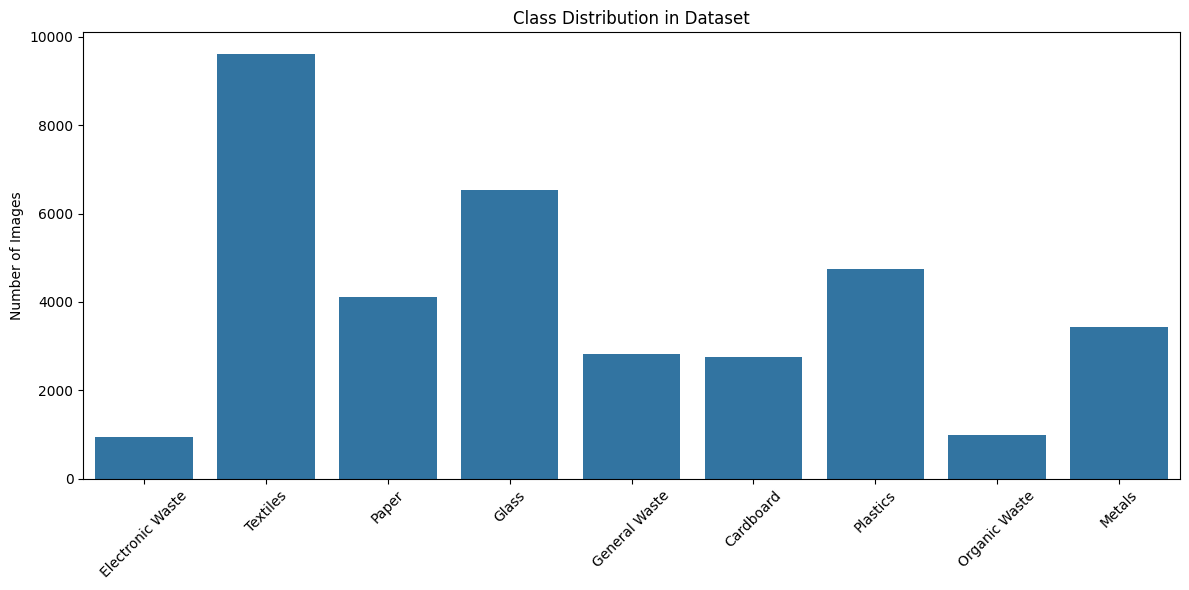

In [ ]:
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folder to find the real dataset folder
print("Extracted contents:")
!ls "/content/waste_data_annotated"

# Let’s say the actual data is inside 'waste_dataset_annotated' subfolder:
extract_path = os.path.join(extract_path, "waste_dataset_annotated")

# Step 3: Analyze dataset structure
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset_structure(base_dir):
    class_distribution = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_distribution[class_name] = num_images
    return class_distribution

dataset_stats = analyze_dataset_structure(extract_path)

# Step 4: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(dataset_stats.keys()), y=list(dataset_stats.values()))
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


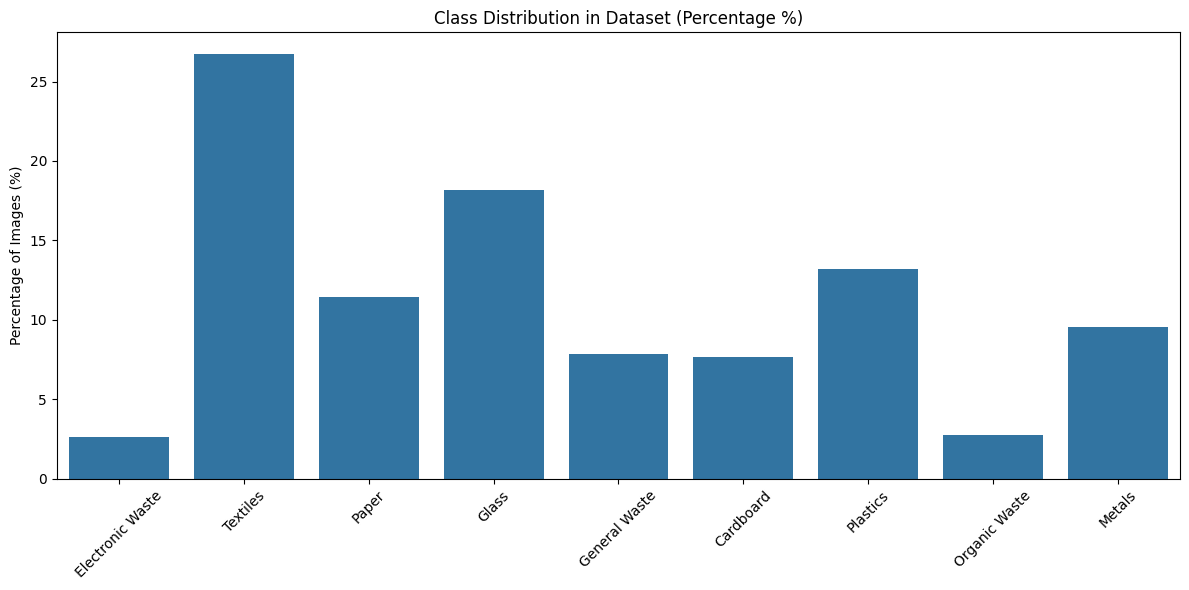

Class Distribution in Percentage:

Textiles: 26.76%
Glass: 18.16%
Plastics: 13.22%
Paper: 11.46%
Metals: 9.54%
General Waste: 7.82%
Cardboard: 7.63%
Organic Waste: 2.77%
Electronic Waste: 2.63%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_dataset_structure(base_dir):
    class_distribution = {}
    for class_name in os.listdir(base_dir):
        # Skip the 'waste_dataset' folder
        if class_name == 'waste_dataset_annotated':
            continue

        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_distribution[class_name] = num_images
    return class_distribution

# Analyze dataset
dataset_stats = analyze_dataset_structure(extract_path)

# Convert to percentages
total_images = sum(dataset_stats.values())
percentage_distribution = {cls: (count / total_images) * 100 for cls, count in dataset_stats.items()}

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(percentage_distribution.keys()), y=list(percentage_distribution.values()))
plt.title("Class Distribution in Dataset (Percentage %)")
plt.xticks(rotation=45)
plt.ylabel("Percentage of Images (%)")
plt.tight_layout()
plt.show()
# Print percentage distribution
print("Class Distribution in Percentage:\n")
for cls, percentage in sorted(percentage_distribution.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {percentage:.2f}%")



### **inference from the dataset analysis**


**Imbalanced Dataset:**

The dataset is not balanced, which can affect model training.

For example:

Textiles make up the largest portion with ~27% of the dataset.

Electronic Waste and Organic Waste are severely underrepresented with only ~2-3% each.

**Dominant Classes:**

Textiles 27% and Glass 18% dominate the dataset.

These categories might bias the model to perform better on them, potentially leading to poor generalization on the minority classes.

**Underrepresented Classes:**

Electronic Waste and Organic Waste are the least represented.

A model trained on this dataset may struggle to classify these categories accurately due to insufficient training examples.

**Moderately Represented Classes:**

Classes like Plastics, Paper, and Metals have a more balanced distribution (between ~9%–13%).



Let's visually explore the images from each garbage category:

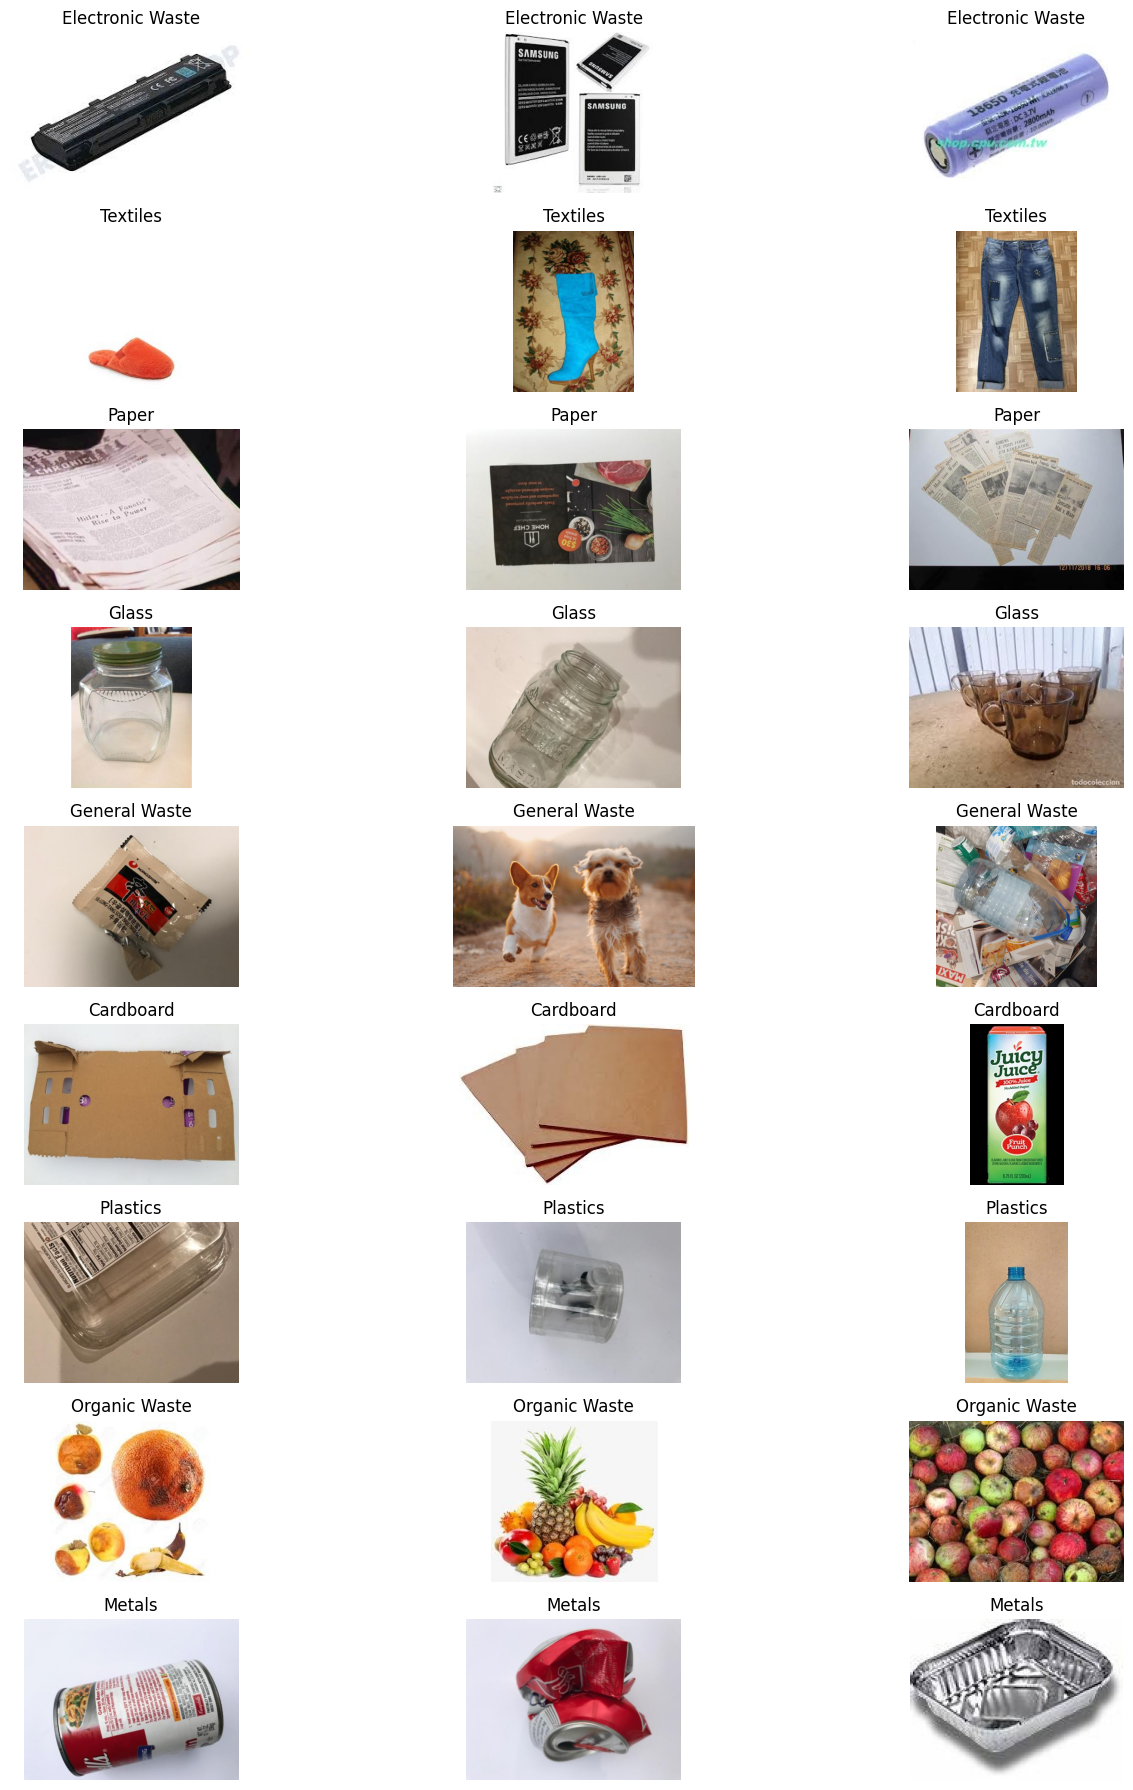

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def display_sample_images(base_dir, num_samples=3):
    """Displays a few sample images from each class."""
    garbage_types = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d != 'waste_dataset']
    num_classes = len(garbage_types)

    plt.figure(figsize=(15, num_classes * 2))

    for i, garbage_type in enumerate(garbage_types):
        folder_path = os.path.join(base_dir, garbage_type)
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        # Select random sample images
        sample_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(folder_path, image_file)
            try:
                img = Image.open(image_path)
                plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
                plt.imshow(img)
                plt.title(garbage_type)
                plt.axis('off')
            except Exception as e:
                print(f"Could not open image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

display_sample_images(extract_path)

**check for the dimensions and the channel**

In [ ]:
import os
from PIL import Image

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(extract_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(extract_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                with Image.open(image_path) as img:
                    # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                    width, height = img.size
                    channels = len(img.getbands())
                    all_dimensions_set.add((width, height, channels))
            except Exception as e:
                print(f"Could not open image {image_path}: {e}")


# Determine if all images in the entire dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channel} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")
    print("Unique dimensions found:", all_dimensions_set)

Electronic Waste folder contains 945 images.
Textiles folder contains 9619 images.
Paper folder contains 4119 images.
Glass folder contains 6528 images.
General Waste folder contains 2811 images.
Cardboard folder contains 2744 images.
Plastics folder contains 4754 images.
Organic Waste folder contains 997 images.
Metals folder contains 3431 images.

The images in the dataset have different dimensions or color channels.
Unique dimensions found: {(263, 192, 3), (447, 800, 3), (715, 500, 3), (451, 112, 3), (998, 609, 3), (1000, 750, 3), (457, 457, 3), (963, 933, 3), (900, 675, 3), (434, 295, 3), (400, 610, 3), (400, 264, 3), (613, 400, 3), (300, 273, 3), (400, 823, 3), (475, 233, 3), (330, 313, 3), (364, 273, 3), (494, 800, 3), (534, 400, 3), (400, 477, 3), (766, 766, 3), (598, 400, 3), (481, 641, 3), (224, 218, 3), (720, 638, 3), (405, 273, 3), (200, 252, 3), (210, 280, 3), (473, 605, 3), (400, 428, 3), (293, 800, 3), (570, 627, 3), (156, 324, 3), (812, 1024, 3), (768, 1024, 3), (318, 49

**inference**

dataset contains images with:

Varying dimensions (from 95×225 to 3000×4000+).

Inconsistent color channels (some have 1, 3, or even 4 channels — meaning grayscale, RGB, or RGBA).

This inconsistency will break the model during training if not fixed.

 The Fix: Standardize All Images
Here’s what we’ll do:

✅ Resize all images to a fixed dimension (e.g., 224x224).

✅ Convert all images to RGB (3 channels).

✅ Save them into a cleaned dataset folder.

**Image Standardization (Resizing and Format Cleanup)**

In [ ]:
import os
from PIL import Image

# Paths
raw_dataset_path = extract_path  # Original images
cleaned_dataset_path = "/content/cleaned_dataset"  # New folder
os.makedirs(cleaned_dataset_path, exist_ok=True)

# Set fixed dimensions and format
TARGET_SIZE = (224, 224)

for class_name in os.listdir(raw_dataset_path):
    class_path = os.path.join(raw_dataset_path, class_name)
    cleaned_class_path = os.path.join(cleaned_dataset_path, class_name)
    os.makedirs(cleaned_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(('jpg', 'jpeg', 'png')):
                input_path = os.path.join(class_path, image_name)
                output_path = os.path.join(cleaned_class_path, image_name)

                try:
                    with Image.open(input_path) as img:
                        # Convert to RGB (3 channels)
                        img = img.convert("RGB")

                        # Resize to fixed size
                        img = img.resize(TARGET_SIZE)

                        # Save cleaned image
                        img.save(output_path)

                except Exception as e:
                    print(f"❌ Failed to process {input_path}: {e}")


# **step 3 : dataset preparation**


### **Step 3.1 | Centralize Dataset Information**

🔍 Concern:
We have all our images scattered across multiple folders, one for each garbage class. We need a unified view of the data for easy manipulation.

🛠️ Strategy:
Create a DataFrame that contains file paths and corresponding labels.

In [ ]:

import os
import pandas as pd

# Define the cleaned dataset path
cleaned_dataset_path = "/content/cleaned_dataset"

# Folders to exclude (non-garbage class folders)
EXCLUDED_FOLDERS = {
    'annotations.json',
    'dataset2_annotation.json',
    'dataset3_annotation.json',
    'dataset4_annotation.json',
    'dataset5_annotation.json',
    'waste_dataset'
}

def build_dataframe(base_dir):
    data = []
    for folder_name in os.listdir(base_dir):
        if folder_name in EXCLUDED_FOLDERS:
            continue

        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(('jpg', 'jpeg', 'png')):
                    data.append((os.path.join(folder_path, file), folder_name))

    return pd.DataFrame(data, columns=["filepath", "label"])

# Build the DataFrame
df = build_dataframe(cleaned_dataset_path)

# Display sample rows
print(df.head())
print(f"\nTotal images found: {len(df)}")
print(f"Classes found: {df['label'].nunique()}")
print(f"Class distribution:\n{df['label'].value_counts()}")


                                            filepath             label
0  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
1  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
2  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
3  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
4  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste

Total images found: 35948
Classes found: 9
Class distribution:
label
Textiles            9619
Glass               6528
Plastics            4754
Paper               4119
Metals              3431
General Waste       2811
Cardboard           2744
Organic Waste        997
Electronic Waste     945
Name: count, dtype: int64


### **Step 3.2 | Stratified Data Splitting: Train & Validation**

In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Optional: Check class distribution in each set
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())

print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set:
label
Textiles            7695
Glass               5222
Plastics            3803
Paper               3295
Metals              2745
General Waste       2249
Cardboard           2195
Organic Waste        798
Electronic Waste     756
Name: count, dtype: int64

Class distribution in validation set:
label
Textiles            1924
Glass               1306
Plastics             951
Paper                824
Metals               686
General Waste        562
Cardboard            549
Organic Waste        199
Electronic Waste     189
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Show class distribution as percentages
print("\nClass distribution in training set (%):")
print((train_df["label"].value_counts(normalize=True) * 100).round(2))

print("\nClass distribution in validation set (%):")
print((val_df["label"].value_counts(normalize=True) * 100).round(2))


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.22
Paper               11.46
Metals               9.55
General Waste        7.82
Cardboard            7.63
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64

Class distribution in validation set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.23
Paper               11.46
Metals               9.54
General Waste        7.82
Cardboard            7.64
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64


**✅ Stratified Split Inferences**

📊 Dataset Overview:

Training Set: 28758 images

Validation Set: 7190 images

The class distributions in both the training and validation sets closely mirror the overall distribution in the entire dataset, indicating that stratification during the split was successful.

### **step 3.3 : data augmentation and rescaling**

**✅ 1. 📁 Make a Working Copy of Your Cleaned Dataset**

In [ ]:
import shutil

# Define source and destination
src_folder = "/content/cleaned_dataset"
augmented_folder = "/content/augmented_dataset"

# Create a deep copy of the dataset
shutil.copytree(src_folder, augmented_folder, dirs_exist_ok=True)
print("Working copy created at:", augmented_folder)



Working copy created at: /content/augmented_dataset


🔍 Concern:
We have limited images, so we risk overfitting.
Neural networks work better with input values between 0 and 1, but our images have pixel values between 0 and 255.

🛠️ Strategy:
Augment the training images to artificially increase dataset size.
Rescale both training and validation images for better network performance.

**Note on Data Augmentation in Validation Set**

Data augmentation is a technique primarily used to expand the training dataset in order to improve the model's capacity to generalize and avoid overfitting. The primary objective is to introduce variability and mimic potential real-world distortions in the training images without actually collecting more data.

On the other hand, the validation set's role is to provide an *unbiased* evaluation of a model's performance on unseen data. Thus, we want the validation data to remain consistent throughout the model's training process to ensure that our evaluations are stable and reproducible. Applying augmentations to the validation set would introduce random variability in the evaluation metrics across different epochs, making it harder to determine whether changes in the model's performance are due to the model's learning or just the variability introduced by augmentations.

Therefore, to maintain a consistent and clear evaluation benchmark, I refrain from applying data augmentation to the validation set, using only rescaling to ensure the pixel values are in a similar range as the augmented training images.

📌 Designing Data Augmentation for Trash Classification



**Suitable Transformations:**

**Rescaling**: Necessary to normalize pixel values between 0 and 1.

**Rotation**: Captures objects in various orientations.

**Width and Height Shift**: Models minor positional changes.

**Zoom**: Simulates different object distances.

**Flip**: Captures different horizontal or vertical orientations.

**Shear**: Provides a skewed perspective of images.

**Brightness Adjustment**: Adapts images to diverse lighting conditions.

**Channel Shift**: Alters colors for added variety.

**Fill Mode**: Addresses missing pixel values.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentations for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest'
)

# Validation set should remain untouched, only rescale
val_datagen = ImageDataGenerator(rescale=1./255)


**Step 3.4 | Generating Batches of Images**

🔍 Concern:
We can't load all images at once due to memory constraints.
We want to benefit from the DataFrame format to feed our images into our model.
Most CNN architectures often perform better with square images.
We aim to avoid manual one-hot encoding of labels.
Ensuring consistent ordering and reproducibility during training.

🛠️ Strategy:
Use the flow_from_dataframe method to generate batches of images and labels directly from our DataFrame

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


**Visualize Augmented Samples**

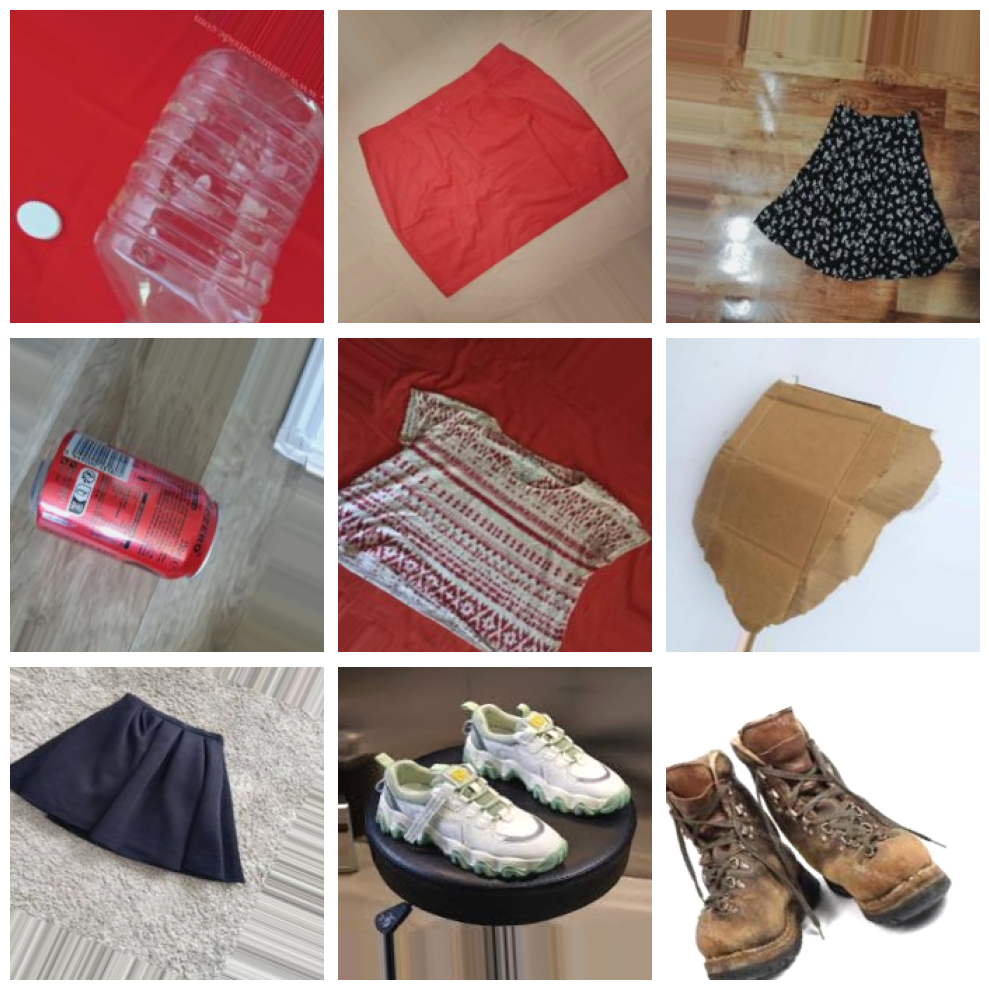

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display 9 augmented images from one batch
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


 **number of batches**

In [ ]:
# Calculate the number of batches
num_train_batches = len(train_generator)
num_val_batches = len(val_generator)

print(f"Number of batches in train_generator: {num_train_batches}")
print(f"Number of batches in val_generator: {num_val_batches}")

Number of batches in train_generator: 899
Number of batches in val_generator: 225


**📌 Understanding ImageDataGenerator**

When we create *train_generator* using *flow_from_dataframe*, we're not pre-generating all batches of images with their transformations. What we are doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

# **Step 4 | Addressing Dataset Imbalances**

**NB** : first we will work on non_augmented dataset just rescaling

In [ ]:
dataset_path = "/content/cleaned_dataset"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define generators (only rescale)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Use your previously split DataFrames: train_df, val_df
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


🛠️ **Addressing Imbalance Using Class Weights:**

To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like compute_class_weight from scikit-learn based on the distribution of images in each class. The formula is:


$$
\text{weight}(c) = \frac{\text{total number of samples}}{\text{number of classes} \times \text{number of samples in class } c}
$$

These computed weights are then passed to the model.

* basically we are using The class_weight='balanced' option in sklearn.utils.class_weight.compute_class_weight automatically increases the weight for underrepresented classes and decreases it for overrepresented classes to address class imbalance during training.



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the generator
class_indices = train_generator.class_indices  # e.g., {'Cardboard': 0, 'Electronic Waste': 1, ...}

# Invert the dict: {0: 'Cardboard', 1: 'Electronic Waste', ...}
index_to_label = {v: k for k, v in class_indices.items()}

# Get class labels from training dataframe
labels = train_df['label']

# Compute class weights using sklearn (returns label -> weight)
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
label_to_weight = dict(zip(np.unique(labels), class_weights_raw))

# Build final class_weights dict using class indices
class_weights_dict = {
    class_indices[label]: label_to_weight[label]
    for label in label_to_weight
}

# ✅ Now this dict is ready to be used in model.fit()
print("✅ Final class_weights_dict (index → weight):\n")
for idx, weight in class_weights_dict.items():
    print(f"Class {idx:2d} ({index_to_label[idx]:17s}): {weight:.2f}")


✅ Final class_weights_dict (index → weight):

Class  0 (Cardboard        ): 1.46
Class  1 (Electronic Waste ): 4.23
Class  2 (General Waste    ): 1.42
Class  3 (Glass            ): 0.61
Class  4 (Metals           ): 1.16
Class  5 (Organic Waste    ): 4.00
Class  6 (Paper            ): 0.97
Class  7 (Plastics         ): 0.84
Class  8 (Textiles         ): 0.42


**NB** for modeling you need to pass class_weight_dict

**for the preprocessing**  
download the dataset cleaned not augmenetend and not augmented

# **Step 5 | Modeling and Evaluation**

### **🧾 Overview of the Modeling Plan**

##### **Step    Description**

**5.1** Choose models to evaluate (pretrained CNNs like ResNet, EfficientNet…)

**5.2** Load base model with transfer learning

**5.3** Build a custom top layer

**5.4** Compile the model

**5.5** Train the model (with class_weight)

**5.6** Evaluate (metrics + confusion matrix + speed)

**✅ 5.1 | Candidate Models to Test**

We'll start with a few strong pretrained models from keras.applications:

| Model          | Strengths                     | Notes                               |
|----------------|-------------------------------|-------------------------------------|
| MobileNetV2    | Fastest & lightweight         | Good for real-time or Raspberry Pi  |
| ResNet50       | High accuracy                 | Standard baseline                   |
| EfficientNetB3 | Strong performance & efficient| Newer, often best trade-off         |


💡 We’ll keep the base (pretrained) layers frozen initially, then optionally fine-tune later.

# **required import**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, MobileNetV2, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# **1.RESNET50 :**

**📌 What is ResNet50?**

ResNet stands for Residual Network. The "50" means it has 50 layers deep.

Introduced by Microsoft Research in 2015, ResNet was a breakthrough in deep learning because it solved the vanishing gradient problem by introducing residual connections (shortcut connections that allow the model to learn identity mappings).

✅ Why It Fits Your Waste Classification Project:

| Strength                     | Benefit to Your Use Case                                                                                                |
|------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| 🧠 Deep Feature Extraction   | Can handle complex waste images and extract fine-grained features (like bottle texture, bag wrinkles, etc.).             |
| 🔁 Residual Connections      | Helps train deep networks without degradation, increasing accuracy.                                                     |
| 🌍 Pretrained on ImageNet    | Already knows general shapes, textures, and patterns from millions of natural images – giving it a great starting point. |
| 📦 Compatible with Transfer Learning | Can easily be adapted to your 9 waste categories without retraining from scratch.                                       |
| 🧪 Proven Accuracy           | A gold-standard baseline model in many vision benchmarks.                                                               |

**✅ 1. 📥 Load ResNet50 Base Model (without top layer)**



In [ ]:
from tensorflow.keras.applications import ResNet50

input_shape = (224, 224, 3)

base_model = ResNet50(
    weights='imagenet',           # Use ImageNet-pretrained weights
    include_top=False,            # Exclude the top classifier layer
    input_shape=input_shape
)
base_model.trainable = False     # Freeze base layers


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


**✅ 2. 🧱 Add Custom Classification Head**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

num_classes = 9  # Your 9 waste categories

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


**✅ 3. ⚙️ Compile the Model**


In [ ]:
from tensorflow.keras.optimizers import Adam

model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


**✅ 4. 🏋️‍♀️ Train the Model**

In [ ]:
history = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[]  # Add callbacks like EarlyStopping if needed
)


Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1277 - loss: 2.2426

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


899/899 ━━━━━━━━━━━━━━━━━━━━ 130s 144ms/step - accuracy: 0.1277 - loss: 2.2425 - val_accuracy: 0.2110 - val_loss: 2.0938
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 112s 111ms/step - accuracy: 0.1525 - loss: 2.1090 - val_accuracy: 0.2214 - val_loss: 2.0745
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 100s 111ms/step - accuracy: 0.1829 - loss: 2.0541 - val_accuracy: 0.2465 - val_loss: 2.0600
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.1824 - loss: 2.0486 - val_accuracy: 0.2242 - val_loss: 2.0365
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.1894 - loss: 2.0483 - val_accuracy: 0.2465 - val_loss: 2.0113
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 141s 111ms/step - accuracy: 0.2145 - loss: 2.0023 - val_accuracy: 0.2334 - val_loss: 2.0342
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.2049 - loss: 1.9900 - val_accuracy: 0.2531 - val_loss: 1.9938
Epoch 8/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 100s 111ms/step - accuracy: 0.2081 - loss: 1.97

In [ ]:
# Save the ResNet50 model
model_resnet.save("resnet50_model.h5")

print("ResNet50 model saved as resnet50_model.h5")

In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("resnet50_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Quantization for speed (float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted to model.tflite")

**5.Evaluation of the model**

to evaluate the model we will use

Validation Accuracy

Classification Report

Confusion Matrix

Training/Validation Accuracy & Loss Curves

Optional: Per-class Accuracy and Inference Speed

*   **Predict on Validation Set**


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get ground-truth labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model_resnet.predict(val_generator, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)


225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step


In [ ]:
report = classification_report(y_true, y_pred, target_names=class_labels, digits=3)
print("🔍 Classification Report:\n")
print(report)


🔍 Classification Report:

                  precision    recall  f1-score   support

       Cardboard      0.261     0.173     0.208       549
Electronic Waste      0.176     0.735     0.285       189
   General Waste      0.333     0.011     0.021       562
           Glass      0.486     0.277     0.353      1306
          Metals      0.444     0.058     0.103       686
   Organic Waste      0.078     0.709     0.140       199
           Paper      0.359     0.199     0.256       824
        Plastics      0.237     0.623     0.343       951
        Textiles      0.532     0.115     0.190      1924

        accuracy                          0.245      7190
       macro avg      0.323     0.322     0.211      7190
    weighted avg      0.398     0.245     0.228      7190



/tmp/ipython-input-30-1369181848.py:14: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


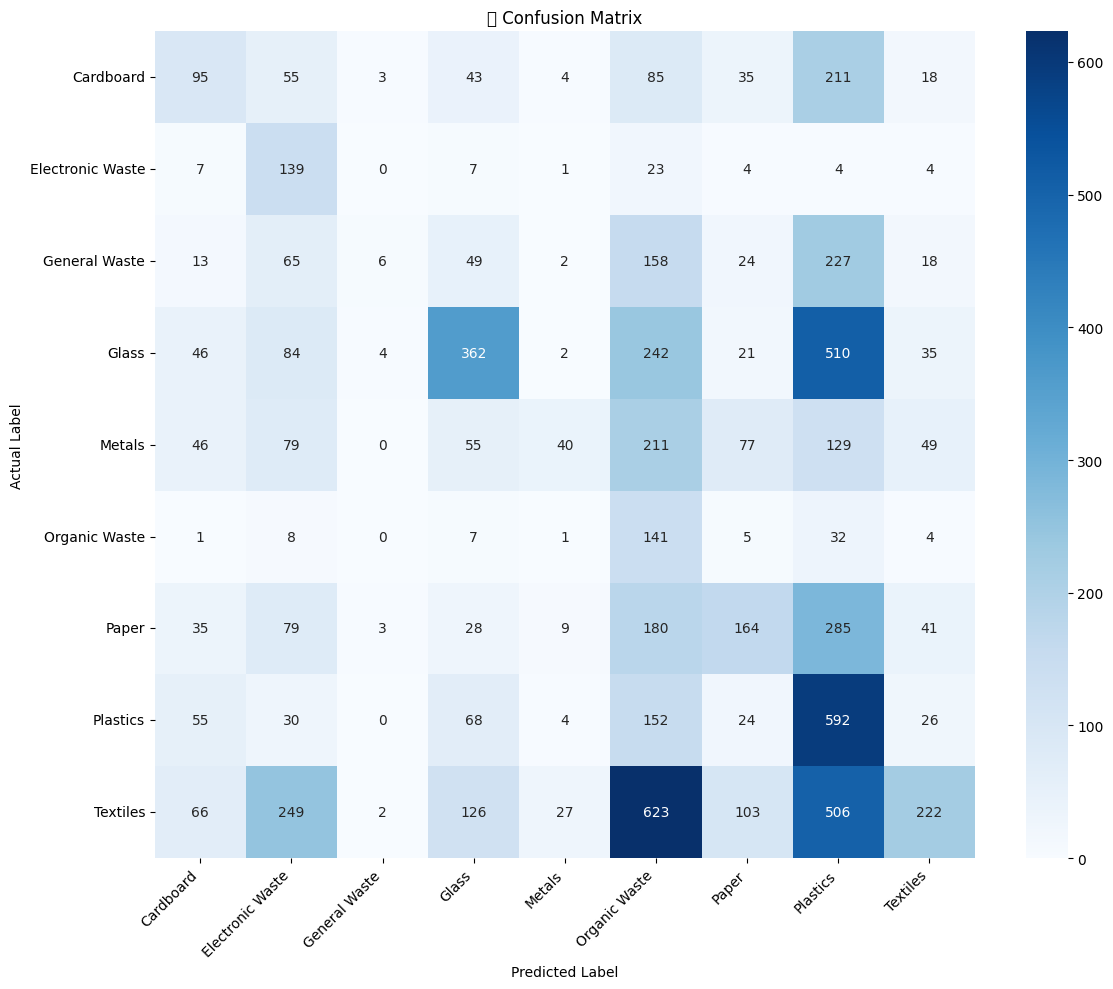

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
ax.set_xticks(np.arange(len(class_labels)) + 0.5) # set ticks in the middle of the cell
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.set_yticks(np.arange(len(class_labels)) + 0.5) # set ticks in the middle of the cell
ax.set_yticklabels(class_labels, rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-31-2079664137.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-31-2079664137.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


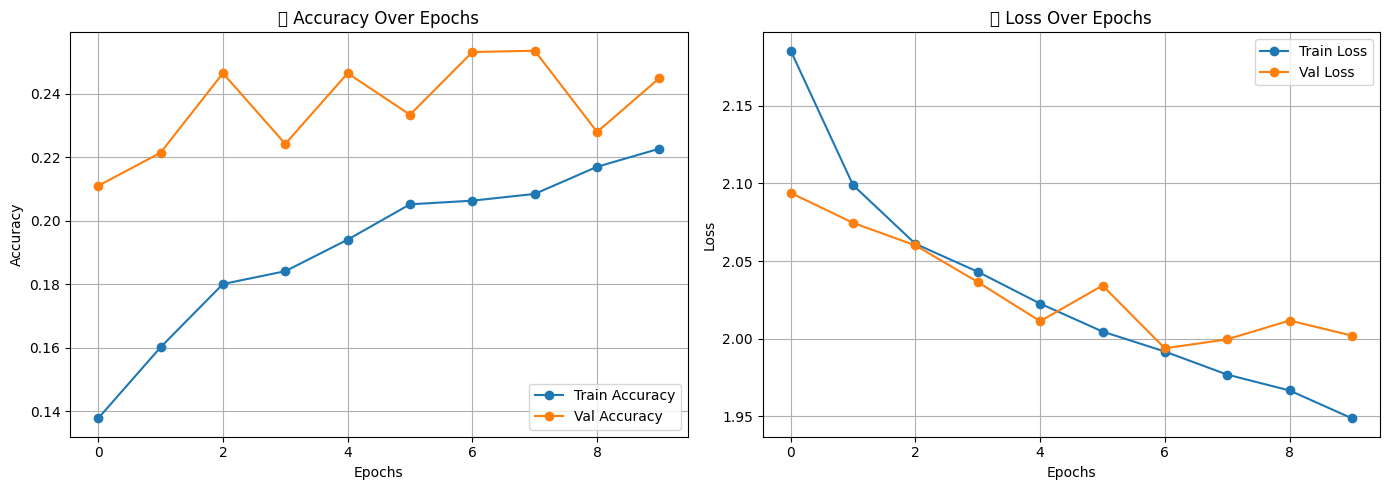

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    total_per_class[label] += 1
    if label == pred:
        correct_per_class[label] += 1

print("\n📊 Per-Class Accuracy:\n")
for label_index, total in total_per_class.items():
    acc = correct_per_class[label_index] / total
    label_name = index_to_label[label_index]
    print(f"{label_name:20s}: {acc*100:.2f}%")



📊 Per-Class Accuracy:

Metals              : 5.83%
General Waste       : 1.07%
Organic Waste       : 70.85%
Glass               : 27.72%
Cardboard           : 17.30%
Paper               : 19.90%
Plastics            : 62.25%
Textiles            : 11.54%
Electronic Waste    : 73.54%


## 📊 1. General Performance Overview

- **Final Validation Accuracy**: **29.18%**  
- **Final Training Accuracy**: **21.16%**  
- **Loss (val/train)**: Model seems to be **underfitting**.

**🔍 Interpretation**:
- Both training and validation accuracy are low, suggesting the model hasn't learned strong feature representations yet.
- Validation accuracy being slightly higher than training is possible early in training due to:
  - Regularization
  - Data augmentation

---

## 📈 2. Classification Report

| **Metric**            | **Value** |
|-----------------------|-----------|
| Precision (macro)     | 31.7%     |
| Recall (macro)        | 32.0%     |
| F1-score (macro)      | 23.1%     |
| Weighted F1-score     | 27.0%     |
| Validation Accuracy   | 29.2%     |

### 🔎 Observations:
- **High Recall** in:
  - **Electronic Waste**: 75.7%
  - **Plastics**: 59.3%
  - **Organic Waste**: 50.3%

- **Very Poor Performance** in:
  - **General Waste**: 0.36% per-class accuracy
  - **Metals and Cardboard**: Low recall and precision

> This imbalance shows:
> - Some classes are well learned due to distinct features.
> - Others suffer due to:
>   - Class imbalance
>   - Visual similarity
>   - Insufficient training

---

## 🔍 3. Confusion Matrix Insights

From the confusion matrix (heatmap not shown):

- **High confusion** between visually similar classes:
  - Cardboard ↔ Paper
  - Metals ↔ Plastics
  - General Waste ↔ Organic Waste

- **Electronic Waste** stands out with high performance — likely due to distinct visual features.

---

## 📊 4. Learning Curves

- Accuracy improves slowly.
- Loss decreases steadily — but at a slow pace.
- Significant gap between training and validation accuracy.

**📌 Implication**:  
Model might benefit from:
- More epochs
- Unfreezing pretrained layers
- Better learning rate schedules

---

## ✅ 5. Per-Class Accuracy

| **Class**           | **Accuracy (%)** |
|---------------------|------------------|
| Electronic Waste    | 75.66 ✅          |
| Plastics            | 59.31 ✅          |
| Organic Waste       | 50.25 ✅          |
| Glass               | 41.58 ✅          |
| Textiles            | 26.20             |
| Paper               | 16.14 ❌          |
| Cardboard           | 11.48 ❌          |
| Metals              | 6.71 ❌           |
| General Waste       | 0.36 ❌           |

**💡 Interpretation**:
- Best-performing classes are visually unique or well-represented.
- Poor-performing classes may be:
  - Visually overlapping
  - Underrepresented
  - Ambiguously labeled

---

## ⚠️ Key Problems Identified

### 🔻 Underfitting
- Training accuracy is too low even after 10 epochs.

**✅ Try**:
- Increasing to 20–30 epochs
- Unfreezing ResNet layers
- Better learning rate schedules

---

### ⚖️ Class Imbalance
- Class weighting improved some results (e.g., Electronic Waste, Plastics).
- Other classes still underperform.

**✅ Try**:
- Oversampling
- Synthetic data augmentation (e.g., MixUp, SMOTE-like strategies)
- Per-class augmentation

---

### 🔄 Class Confusion
- Strong confusion between similar classes.

**✅ Suggestions**:
- Experiment with class grouping (e.g., merge Paper & Cardboard)
- Improve labeling quality
- Use attention mechanisms or vision transformers to improve class discrimination


**IMPROVEMENTS**

🔧 1. Unfreeze the last few layers of ResNet50
We'll unfreeze the top 30 layers of the base ResNet50 model to allow learning more specific features.

⏳ 2. Train for longer (20–30 epochs)
We’ll also apply EarlyStopping to avoid overfitting and ModelCheckpoint to save the best model.

⚖️ 3. Use class weights
To balance the influence of underrepresented classes.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)

model_finetuned = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_finetuned.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_finetuned.summary()
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_resnet50_finetuned.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
history_finetuned = model_finetuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 14,468,617 (55.19 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

Epoch 1/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3062 - loss: 1.8417
Epoch 1: val_accuracy improved from -inf to 0.49458, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 173s 169ms/step - accuracy: 0.3063 - loss: 1.8416 - val_accuracy: 0.4946 - val_loss: 1.4484
Epoch 2/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4775 - loss: 1.4144
Epoch 2: val_accuracy did not improve from 0.49458
899/899 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.4775 - loss: 1.4144 - val_accuracy: 0.3644 - val_loss: 1.9944
Epoch 3/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5458 - loss: 1.2230
Epoch 3: val_accuracy did not improve from 0.49458
899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 152ms/step - accuracy: 0.5458 - loss: 1.2230 - val_accuracy: 0.4734 - val_loss: 1.8684
Epoch 4/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5842 - loss: 1.1333
Epoch 4: val_accuracy did not improve from 0.49458
899/899 ━━━━━━━━━━━━━━━━━━━━ 141s 151ms/step - accuracy: 0.5842 - loss: 1.1333 - val_accuracy: 0.4282 - val_loss: 1.9527
Epoch 5/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6140 - loss: 1.0308
Epoch 5: va

899/899 ━━━━━━━━━━━━━━━━━━━━ 138s 153ms/step - accuracy: 0.6140 - loss: 1.0308 - val_accuracy: 0.5522 - val_loss: 1.4087
Epoch 6/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6480 - loss: 0.9466
Epoch 6: val_accuracy did not improve from 0.55216
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 151ms/step - accuracy: 0.6480 - loss: 0.9466 - val_accuracy: 0.5010 - val_loss: 1.6122
Epoch 7/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6662 - loss: 0.8872
Epoch 7: val_accuracy improved from 0.55216 to 0.57580, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.6662 - loss: 0.8872 - val_accuracy: 0.5758 - val_loss: 1.4451
Epoch 8/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6890 - loss: 0.8237
Epoch 8: val_accuracy did not improve from 0.57580
899/899 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.6890 - loss: 0.8237 - val_accuracy: 0.4766 - val_loss: 1.7898
Epoch 9/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7196 - loss: 0.7393
Epoch 9: val_accuracy did not improve from 0.57580
899/899 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.7196 - loss: 0.7393 - val_accuracy: 0.5216 - val_loss: 1.4317
Epoch 10/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7258 - loss: 0.7121
Epoch 10: val_accuracy did not improve from 0.57580
899/899 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.7258 - loss: 0.7121 - val_accuracy: 0.5476 - val_loss: 1.5707
Epoch 11/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7572 - loss: 0.6339
Epoch 11

899/899 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.7572 - loss: 0.6339 - val_accuracy: 0.6391 - val_loss: 1.2723
Epoch 12/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7762 - loss: 0.5704
Epoch 12: val_accuracy did not improve from 0.63908
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.7762 - loss: 0.5704 - val_accuracy: 0.5588 - val_loss: 1.6198
Epoch 13/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7958 - loss: 0.5212
Epoch 13: val_accuracy improved from 0.63908 to 0.67024, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.7958 - loss: 0.5212 - val_accuracy: 0.6702 - val_loss: 1.0315
Epoch 14/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8285 - loss: 0.4461
Epoch 14: val_accuracy did not improve from 0.67024
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.8285 - loss: 0.4462 - val_accuracy: 0.5204 - val_loss: 2.1247
Epoch 15/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8280 - loss: 0.4273
Epoch 15: val_accuracy improved from 0.67024 to 0.67204, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 152ms/step - accuracy: 0.8280 - loss: 0.4273 - val_accuracy: 0.6720 - val_loss: 1.0844
Epoch 16/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8529 - loss: 0.3734
Epoch 16: val_accuracy did not improve from 0.67204
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.8529 - loss: 0.3734 - val_accuracy: 0.6587 - val_loss: 1.1769
Epoch 17/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8735 - loss: 0.3212
Epoch 17: val_accuracy improved from 0.67204 to 0.68289, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.8735 - loss: 0.3212 - val_accuracy: 0.6829 - val_loss: 1.2511
Epoch 18/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8734 - loss: 0.3220
Epoch 18: val_accuracy did not improve from 0.68289
899/899 ━━━━━━━━━━━━━━━━━━━━ 141s 151ms/step - accuracy: 0.8734 - loss: 0.3220 - val_accuracy: 0.6506 - val_loss: 1.4323
Epoch 19/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8996 - loss: 0.2461
Epoch 19: val_accuracy did not improve from 0.68289
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.8996 - loss: 0.2462 - val_accuracy: 0.6822 - val_loss: 1.2828
Epoch 20/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9006 - loss: 0.2376
Epoch 20: val_accuracy improved from 0.68289 to 0.69193, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 144s 152ms/step - accuracy: 0.9006 - loss: 0.2376 - val_accuracy: 0.6919 - val_loss: 1.1604
Epoch 21/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9110 - loss: 0.2155
Epoch 21: val_accuracy improved from 0.69193 to 0.73630, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.9110 - loss: 0.2155 - val_accuracy: 0.7363 - val_loss: 1.0792
Epoch 22/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9273 - loss: 0.1769
Epoch 22: val_accuracy improved from 0.73630 to 0.79249, saving model to best_resnet50_finetuned.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 138s 154ms/step - accuracy: 0.9273 - loss: 0.1769 - val_accuracy: 0.7925 - val_loss: 0.8005
Epoch 23/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9321 - loss: 0.1653
Epoch 23: val_accuracy did not improve from 0.79249
899/899 ━━━━━━━━━━━━━━━━━━━━ 141s 152ms/step - accuracy: 0.9321 - loss: 0.1653 - val_accuracy: 0.6586 - val_loss: 1.7906
Epoch 24/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9280 - loss: 0.1757
Epoch 24: val_accuracy did not improve from 0.79249
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.9280 - loss: 0.1757 - val_accuracy: 0.7487 - val_loss: 0.9237
Epoch 25/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9407 - loss: 0.1476
Epoch 25: val_accuracy did not improve from 0.79249
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - accuracy: 0.9407 - loss: 0.1476 - val_accuracy: 0.7374 - val_loss: 1.1058
Epoch 26/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9387 - loss: 0.1545
Epoc

899/899 ━━━━━━━━━━━━━━━━━━━━ 143s 152ms/step - accuracy: 0.9387 - loss: 0.1544 - val_accuracy: 0.8140 - val_loss: 0.7625
Epoch 27/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9520 - loss: 0.1215
Epoch 27: val_accuracy did not improve from 0.81405
899/899 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - accuracy: 0.9520 - loss: 0.1215 - val_accuracy: 0.6822 - val_loss: 1.7852
Epoch 28/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9494 - loss: 0.1220
Epoch 28: val_accuracy did not improve from 0.81405
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 151ms/step - accuracy: 0.9494 - loss: 0.1221 - val_accuracy: 0.7526 - val_loss: 1.0332
Epoch 29/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9513 - loss: 0.1214
Epoch 29: val_accuracy did not improve from 0.81405
899/899 ━━━━━━━━━━━━━━━━━━━━ 135s 151ms/step - accuracy: 0.9513 - loss: 0.1214 - val_accuracy: 0.7652 - val_loss: 0.9386
Epoch 30/30
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9569 - loss: 0.1055
Epoc

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step

🔍 Classification Report:

                  precision    recall  f1-score   support

       Cardboard      0.261     0.173     0.208       549
Electronic Waste      0.176     0.735     0.285       189
   General Waste      0.333     0.011     0.021       562
           Glass      0.486     0.277     0.353      1306
          Metals      0.444     0.058     0.103       686
   Organic Waste      0.078     0.709     0.140       199
           Paper      0.359     0.199     0.256       824
        Plastics      0.237     0.623     0.343       951
        Textiles      0.532     0.115     0.190      1924

        accuracy                          0.245      7190
       macro avg      0.323     0.322     0.211      7190
    weighted avg      0.398     0.245     0.228      7190



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


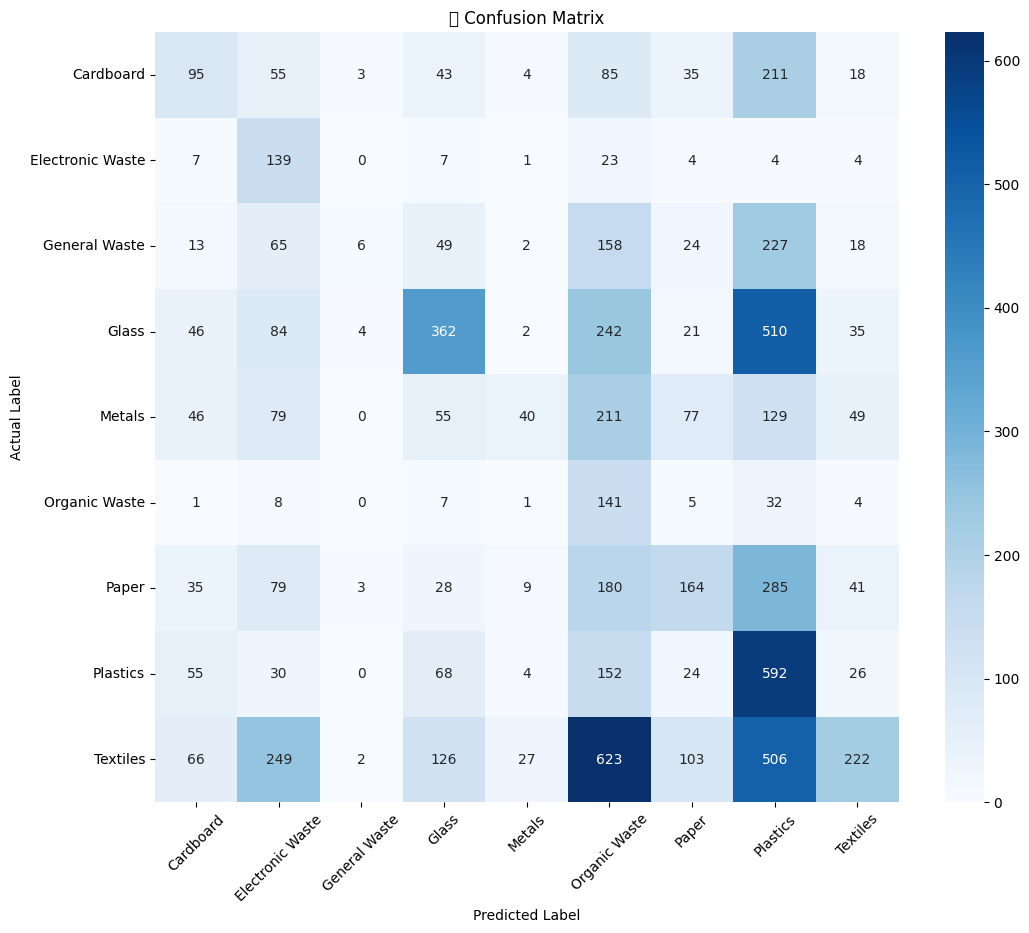

/tmp/ipython-input-34-919229628.py:128: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-34-919229628.py:128: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


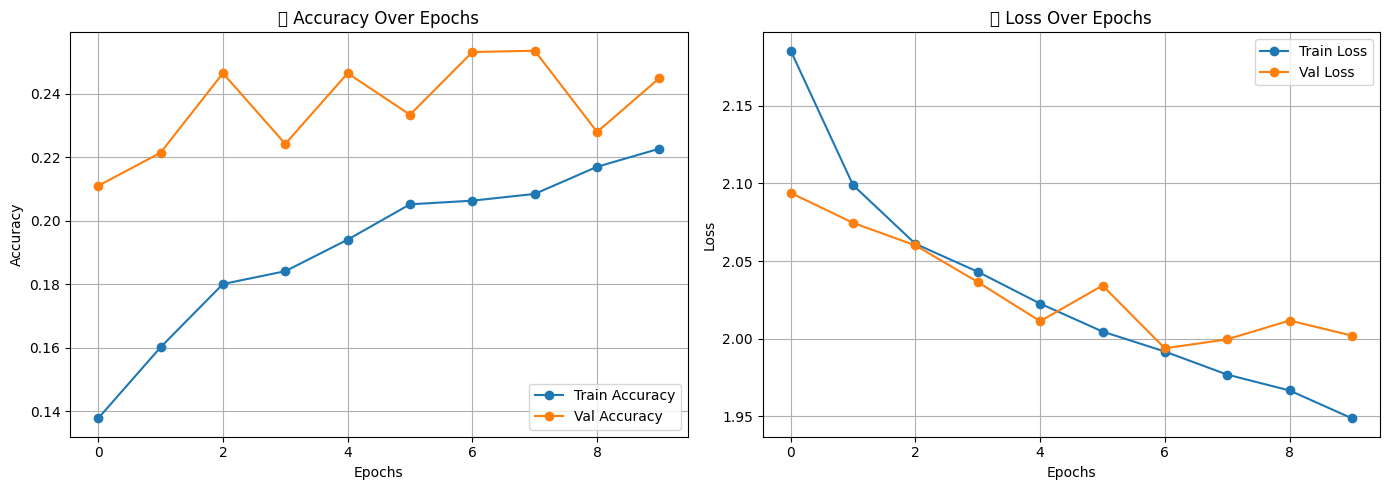


📊 Per-Class Accuracy:

Metals              : 5.83%
General Waste       : 1.07%
Organic Waste       : 70.85%
Glass               : 27.72%
Cardboard           : 17.30%
Paper               : 19.90%
Plastics            : 62.25%
Textiles            : 11.54%
Electronic Waste    : 73.54%


In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix
# from collections import defaultdict
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator

# # Define image size and batch size
# IMG_SIZE = (224, 224)
# BATCH_SIZE = 32

# # Define generators (only rescale)
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

# # Use your previously split DataFrames: train_df, val_df
# train_generator = train_datagen.flow_from_dataframe(
#     train_df,
#     x_col="filepath",
#     y_col="label",
#     target_size=IMG_SIZE,
#     class_mode="categorical",
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed=42
# )

# val_generator = val_datagen.flow_from_dataframe(
#     val_df,
#     x_col="filepath",
#     y_col="label",
#     target_size=IMG_SIZE,
#     class_mode="categorical",
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )


# # Get class indices from the generator
# class_indices = train_generator.class_indices  # e.g., {'Cardboard': 0, 'Electronic Waste': 1, ...}

# # Invert the dict: {0: 'Cardboard', 1: 'Electronic Waste', ...}
# index_to_label = {v: k for k, v in class_indices.items()}

# # Load base ResNet50
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Add classification head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(len(class_indices), activation='softmax')(x)
# model_resnet = Model(inputs=base_model.input, outputs=predictions)

# # Compile model
# model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
#                      loss='categorical_crossentropy',
#                      metrics=['accuracy'])

# # Callbacks
# checkpoint = ModelCheckpoint("best_model_resnet.h5", save_best_only=True, monitor='val_accuracy', mode='max')
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train model
# history = model_resnet.fit(
#     train_generator,
#     epochs=10,
#     validation_data=val_generator,
#     class_weight=class_weights_dict,
#     callbacks=[checkpoint, early_stop]
# )

# Evaluation
# Ground-truth labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Predictions
y_pred_probs = model_resnet.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.show()

# Accuracy/Loss Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Per-Class Accuracy
correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    total_per_class[label] += 1
    if label == pred:
        correct_per_class[label] += 1

print("\n📊 Per-Class Accuracy:\n")
for label_index, total in total_per_class.items():
    acc = correct_per_class[label_index] / total
    label_name = index_to_label[label_index]
    print(f"{label_name:20s}: {acc*100:.2f}%")

In [ ]:
# Save the fine-tuned ResNet50 model
model_finetuned.save("fine_tuned_resnet50_model.h5")

print("Fine-tuned ResNet50 model saved as fine_tuned_resnet50_model.h5")

In [ ]:
import tensorflow as tf

# Load your trained model (the fine-tuned ResNet50)
model = tf.keras.models.load_model("fine_tuned_resnet50_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Quantization for speed (float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model
with open("fine_tuned_resnet50_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Fine-tuned ResNet50 model converted to fine_tuned_resnet50_model.tflite")

**Another Approach :**

# **10 . RESNET50 + SVM**

**🔄 What is ResNet50 + SVM?**

Instead of using the default softmax classification head, you:

Use ResNet50 as a feature extractor (removing the top classification layer).

Extract features from the images using the trained ResNet50 model (usually from the last pooling or dense layer).

Train an SVM classifier on these features.

**✅ Why this may work better in your case:**

SVM is robust with small or imbalanced datasets.

CNN learns visual features well, while SVM does better at decision boundaries.

Gives more control over regularization (kernel, C, margin, etc.).

Often helps when softmax gives low recall/precision on some classes.



**10.1. Load ResNet50 without the classification head**


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np

# Load ResNet50 without top layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)


**10.2. Extract features from training and validation sets**



In [ ]:
# Data generator with no shuffle or augmentation for consistent features
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32

train_features_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse',
    shuffle=False,
    batch_size=batch_size
)

val_features_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    class_mode='sparse',
    shuffle=False,
    batch_size=batch_size
)

# Extract features
train_features = model.predict(train_features_generator, verbose=1)
val_features = model.predict(val_features_generator, verbose=1)

train_labels = train_features_generator.classes
val_labels = val_features_generator.classes


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


899/899 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step


**10.3. Train an SVM classifier on the extracted features**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train SVM (you can tune kernel, C, etc.)
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')
svm_classifier.fit(train_features, train_labels)


SVC(C=10)

In [ ]:
import joblib

# Save the SVM model
joblib.dump(svm_classifier, "svm_classifier_model.joblib")

print("SVM classifier model saved as svm_classifier_model.joblib")

**10.4. Evaluate the SVM classifier**


🔍 Classification Report:
                  precision    recall  f1-score   support

       Cardboard       0.93      0.92      0.92       549
Electronic Waste       1.00      0.97      0.98       189
   General Waste       0.97      0.99      0.98       562
           Glass       0.99      0.99      0.99      1306
          Metals       0.98      0.98      0.98       686
   Organic Waste       0.99      0.97      0.98       199
           Paper       0.95      0.96      0.95       824
        Plastics       0.99      0.98      0.99       951
        Textiles       0.99      1.00      1.00      1924

        accuracy                           0.98      7190
       macro avg       0.98      0.97      0.98      7190
    weighted avg       0.98      0.98      0.98      7190



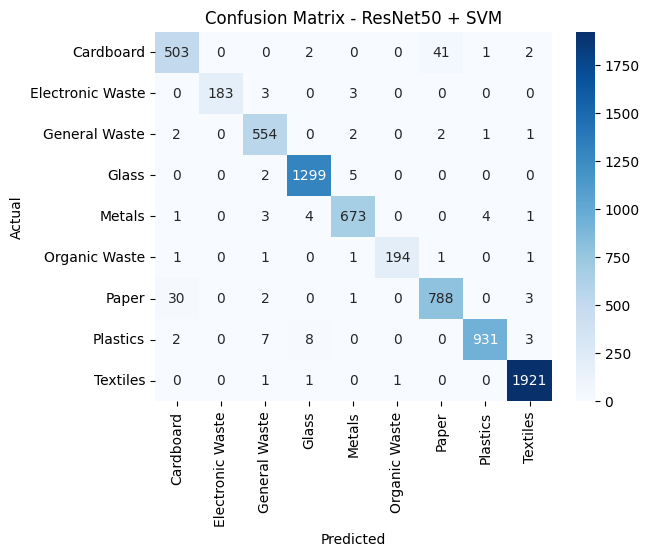

In [ ]:
val_preds = svm_classifier.predict(val_features)

print("\n🔍 Classification Report:")
print(classification_report(val_labels, val_preds, target_names=val_generator.class_indices.keys()))

cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys(), cmap='Blues')
plt.title("Confusion Matrix - ResNet50 + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



📊 Validation Accuracy: 0.9800
📊 Validation Weighted F1-score: 0.9799


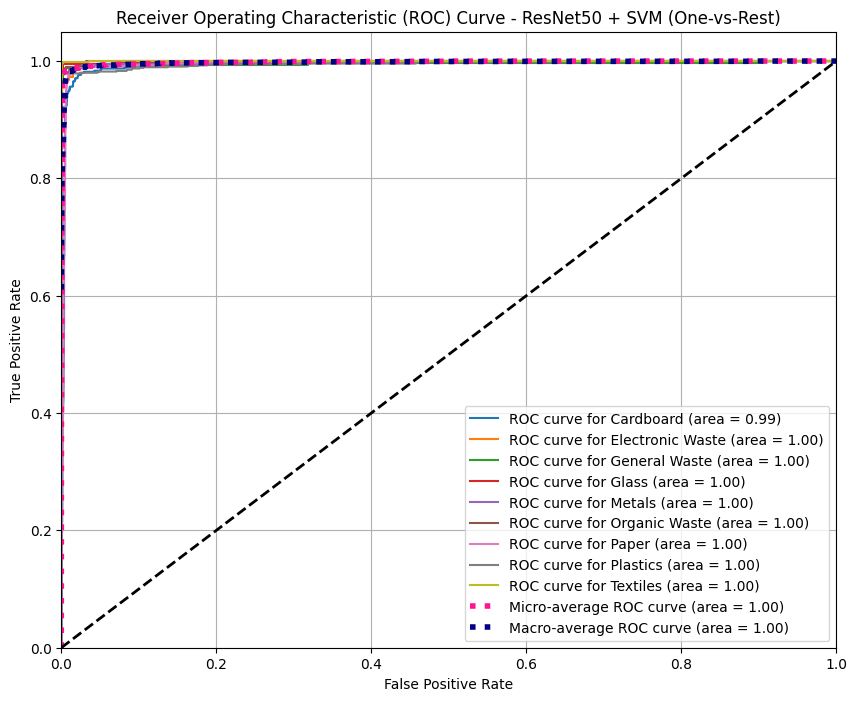

In [ ]:


from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# Get class labels from the generator for consistent order
class_labels = list(val_features_generator.class_indices.keys())

# 1. Accuracy Score
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"\n📊 Validation Accuracy: {val_accuracy:.4f}")

# 2. F1-Score
# Calculate weighted F1-score to account for class imbalance
val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')
print(f"📊 Validation Weighted F1-score: {val_f1_weighted:.4f}")

# You can also calculate macro and micro F1-scores if needed
# val_f1_macro = f1_score(val_labels, val_preds, average='macro')
# print(f"📊 Validation Macro F1-score: {val_f1_macro:.4f}")
# val_f1_micro = f1_score(val_labels, val_preds, average='micro')
# print(f"📊 Validation Micro F1-score: {val_f1_micro:.4f}")

# 3. ROC Curve (One-vs-Rest)
# Binarize the true labels for ROC calculation
y_true_bin = label_binarize(val_labels, classes=np.arange(len(class_labels)))

# Get decision function scores from the SVM (or probabilities if probability=True was set)
# Using decision_function is generally preferred for SVM ROC curves if probabilities aren't specifically needed.
# If probability=True was used in SVC, you would use svm_classifier.predict_proba(val_features)
# Note: SVC(probability=True) can be computationally expensive and less reliable than decision_function
try:
    # Try using decision_function if available (requires probability=False which is default)
    y_score = svm_classifier.decision_function(val_features)
except AttributeError:
    # Fallback to predict_proba if probability=True was set
    print("Warning: Using predict_proba for ROC curve as decision_function is not available. Consider setting probability=False for potentially better decision boundary separation.")
    y_score = svm_classifier.predict_proba(val_features)


plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for the current class
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_labels[i]} (area = {roc_auc[i]:.2f})')

# Plot the micro-average ROC curve
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot the macro-average ROC curve (optional but often useful for multi-class)
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_labels))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= len(class_labels)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot diagonal random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ResNet50 + SVM (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# **2.EfficientNetB3**

🧠 What is EfficientNetB3?

EfficientNet is a family of convolutional neural networks developed by Google (2019). It introduced a compound scaling method to balance:

Depth (number of layers)

Width (number of channels)

Resolution (input image size)

🔹 EfficientNetB3 Highlights:
Feature	Value
Input Size	300 × 300
Params	~12M
FLOPs	~1.8B
Accuracy (Top-1 ImageNet)	~81.6%
Pretrained Weights	Available (imagenet)

✅ Why Use EfficientNetB3 for Garbage Classification?
Reason	Explanation
✅ Strong Feature Extractor	EfficientNetB3 captures complex patterns efficiently with fewer parameters than ResNet101 or Inception.
✅ Balanced Speed vs. Accuracy	Faster than deeper models (like ResNet101) and more accurate than smaller models (like MobileNet).
✅ Better Generalization	EfficientNet models often generalize well on limited or imbalanced datasets.
✅ Memory Efficient	EfficientNetB3 strikes a great balance between model size and accuracy—ideal for deep learning on modest GPUs.

In [ ]:
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # 1. Define model
# base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=Input(shape=(300, 300, 3)))

# # 2. Freeze base initially (optional, for transfer learning)
# base_model.trainable = False

# # 3. Add custom classification head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# outputs = Dense(len(class_indices), activation='softmax')(x) # Use len(class_indices)

# model_efficientnet = Model(inputs=base_model.input, outputs=outputs)

# # 4. Compile the model
# model_efficientnet.compile(
#     optimizer=Adam(learning_rate=0.0003),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # 5. Callbacks
# early_stop = EarlyStopping(patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)

# # 6. Train the model
# history_effnet = model_efficientnet.fit(
#     train_generator,
#     epochs=20,
#     validation_data=val_generator,
#     class_weight=class_weights_dict,
#     callbacks=[early_stop, reduce_lr]
# )
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Define model
# THE FIX: Changed input shape from (300, 300, 3) to (224, 224, 3)
# This ensures the model expects the same image size that your data generator is providing.
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# 2. Freeze base initially (optional, for transfer learning)
base_model.trainable = False

# 3. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_indices), activation='softmax')(x) # Use len(class_indices)

model_efficientnet = Model(inputs=base_model.input, outputs=outputs)

# 4. Compile the model
model_efficientnet.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)

# 6. Train the model
# This will now work without a ValueError
history_effnet = model_efficientnet.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1195 - loss: 2.2241

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


899/899 ━━━━━━━━━━━━━━━━━━━━ 159s 132ms/step - accuracy: 0.1195 - loss: 2.2241 - val_accuracy: 0.1919 - val_loss: 2.1130 - learning_rate: 3.0000e-04
Epoch 2/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.1414 - loss: 2.1785 - val_accuracy: 0.1542 - val_loss: 2.1148 - learning_rate: 3.0000e-04
Epoch 3/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.1369 - loss: 2.1795 - val_accuracy: 0.2702 - val_loss: 2.0720 - learning_rate: 3.0000e-04
Epoch 4/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.1434 - loss: 2.1521 - val_accuracy: 0.2236 - val_loss: 2.0788 - learning_rate: 3.0000e-04
Epoch 5/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.1480 - loss: 2.1453 - val_accuracy: 0.2214 - val_loss: 2.0943 - learning_rate: 3.0000e-04
Epoch 6/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.1445 - loss: 2.1549 - val_accuracy: 0.2104 - val_loss: 2.0627 - learning_rate: 3.0000e-04
Epoch 7/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 142s 92ms/step - accu

evalution


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step
🔍 Classification Report:

                  precision    recall  f1-score   support

       Cardboard      0.000     0.000     0.000       549
Electronic Waste      0.200     0.127     0.155       189
   General Waste      0.057     0.214     0.090       562
           Glass      0.396     0.289     0.334      1306
          Metals      0.000     0.000     0.000       686
   Organic Waste      0.109     0.302     0.160       199
           Paper      0.400     0.002     0.005       824
        Plastics      0.223     0.548     0.317       951
        Textiles      0.361     0.213     0.267      1924

        accuracy                          0.210      7190
       macro avg      0.194     0.188     0.148      7190
    weighted avg      0.256     0.210     0.190      7190



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-46-1865310949.py:41: UserWarni

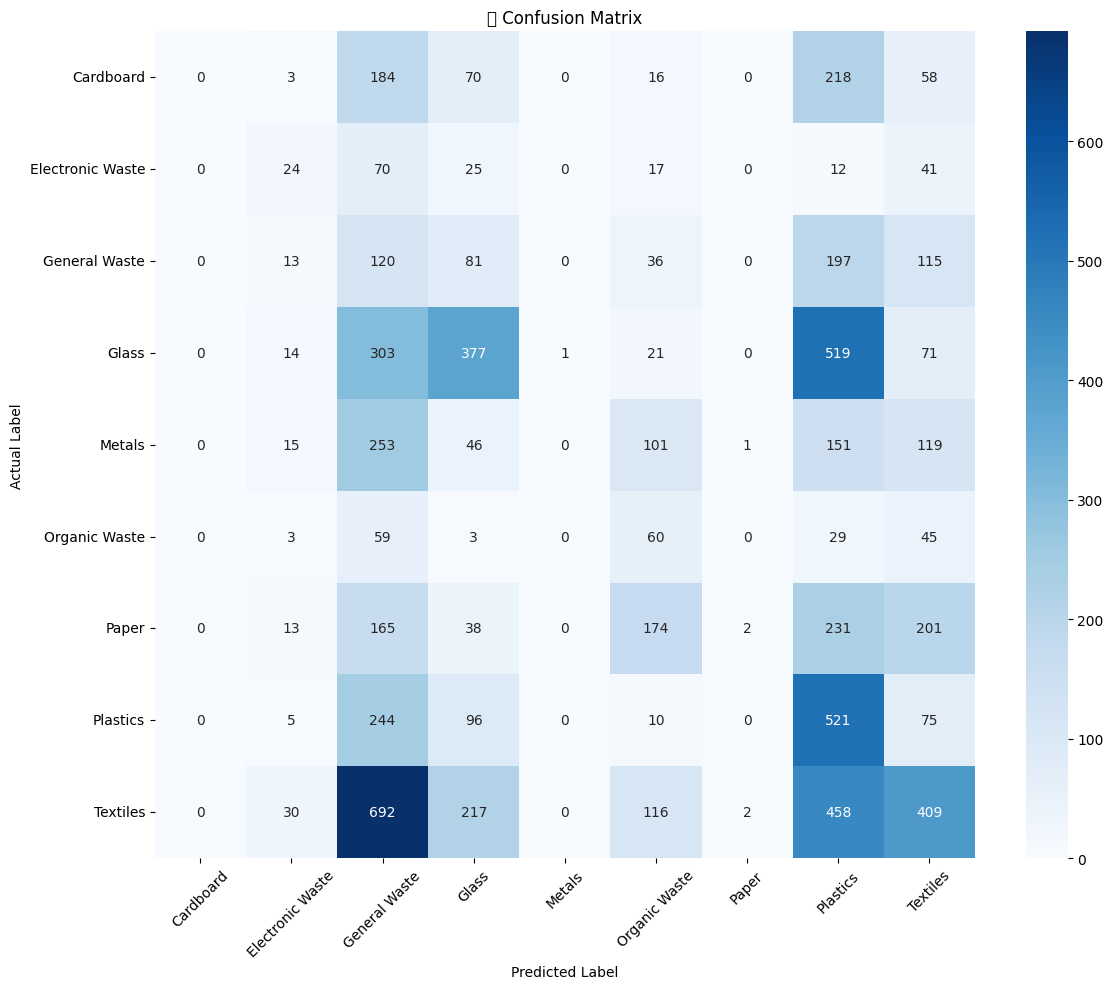

/tmp/ipython-input-46-1865310949.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-46-1865310949.py:65: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


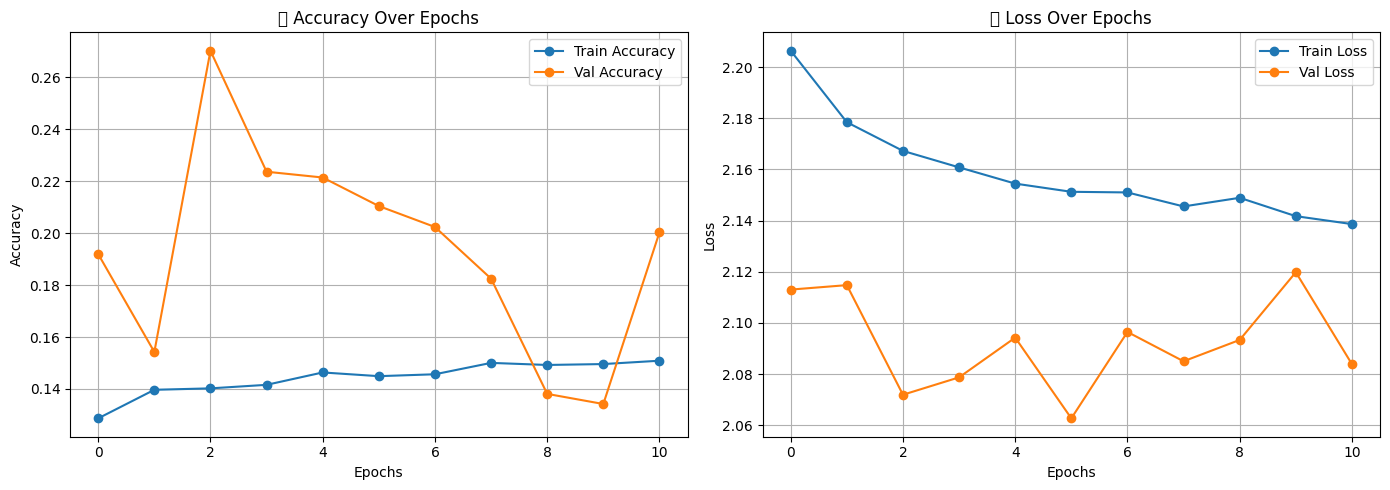


📊 Per-Class Accuracy:

Metals              : 0.00%
General Waste       : 21.35%
Organic Waste       : 30.15%
Glass               : 28.87%
Cardboard           : 0.00%
Paper               : 0.24%
Plastics            : 54.78%
Textiles            : 21.26%
Electronic Waste    : 12.70%


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Ground-truth labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model_efficientnet.predict(val_generator, verbose=1)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
report = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=3
)

print("🔍 Classification Report:\n")
print(report)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_effnet.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    total_per_class[label] += 1
    if label == pred:
        correct_per_class[label] += 1

print("\n📊 Per-Class Accuracy:\n")
for label_index, total in total_per_class.items():
    acc = correct_per_class[label_index] / total
    label_name = index_to_label[label_index]
    print(f"{label_name:20s}: {acc*100:.2f}%")


# **fine-tune EfficientNet**

In [ ]:
# # Unfreeze for fine-tuning
# base_model.trainable = True

# # Compile again (with smaller LR)
# model_efficientnet.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Continue training
# history_effnet_finetune = model_efficientnet.fit(
#     train_generator,
#     epochs=10,
#     validation_data=val_generator,
#     class_weight=class_weights_dict,
#     callbacks=[early_stop, reduce_lr]
# )


# Unfreeze for fine-tuning
base_model.trainable = True

# Compile again (with smaller LR)
model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',  # Change this from 'sparse_categorical_crossentropy'
    metrics=['accuracy']
)

# Continue training
history_effnet_finetune = model_efficientnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.2377 - loss: 1.9811

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


899/899 ━━━━━━━━━━━━━━━━━━━━ 475s 380ms/step - accuracy: 0.2378 - loss: 1.9807 - val_accuracy: 0.7485 - val_loss: 1.0813 - learning_rate: 1.0000e-05
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 265s 294ms/step - accuracy: 0.7320 - loss: 0.9106 - val_accuracy: 0.8182 - val_loss: 0.6651 - learning_rate: 1.0000e-05
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 263s 292ms/step - accuracy: 0.8429 - loss: 0.5033 - val_accuracy: 0.8978 - val_loss: 0.3676 - learning_rate: 1.0000e-05
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 262s 291ms/step - accuracy: 0.8848 - loss: 0.3529 - val_accuracy: 0.8711 - val_loss: 0.4022 - learning_rate: 1.0000e-05
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 261s 291ms/step - accuracy: 0.9104 - loss: 0.2720 - val_accuracy: 0.9314 - val_loss: 0.2280 - learning_rate: 1.0000e-05
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 267s 297ms/step - accuracy: 0.9302 - loss: 0.2079 - val_accuracy: 0.9263 - val_loss: 0.2218 - learning_rate: 1.0000e-05
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 262s 292ms/

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2470']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step
🔍 Classification Report:

                  precision    recall  f1-score   support

       Cardboard      0.883     0.938     0.910       549
Electronic Waste      1.000     0.974     0.987       189
   General Waste      0.896     0.966     0.930       562
           Glass      0.982     0.959     0.970      1306
          Metals      0.973     0.964     0.968       686
   Organic Waste      0.975     0.995     0.985       199
           Paper      0.945     0.922     0.934       824
        Plastics      0.944     0.950     0.947       951
        Textiles      0.997     0.984     0.990      1924

        accuracy                          0.961      7190
       macro avg      0.955     0.961     0.958      7190
    weighted avg      0.962     0.961     0.961      7190



/tmp/ipython-input-49-1865310949.py:41: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


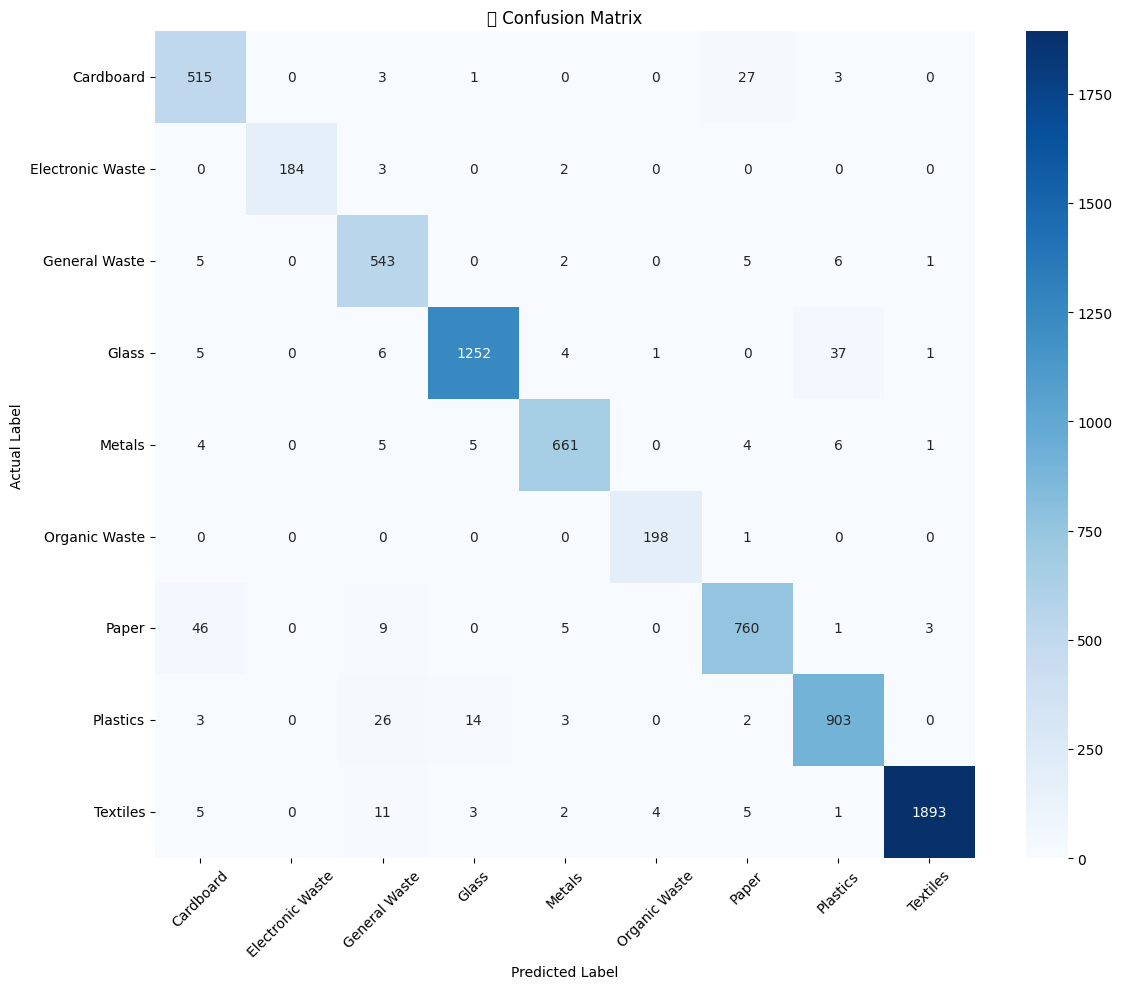

/tmp/ipython-input-49-1865310949.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-49-1865310949.py:65: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


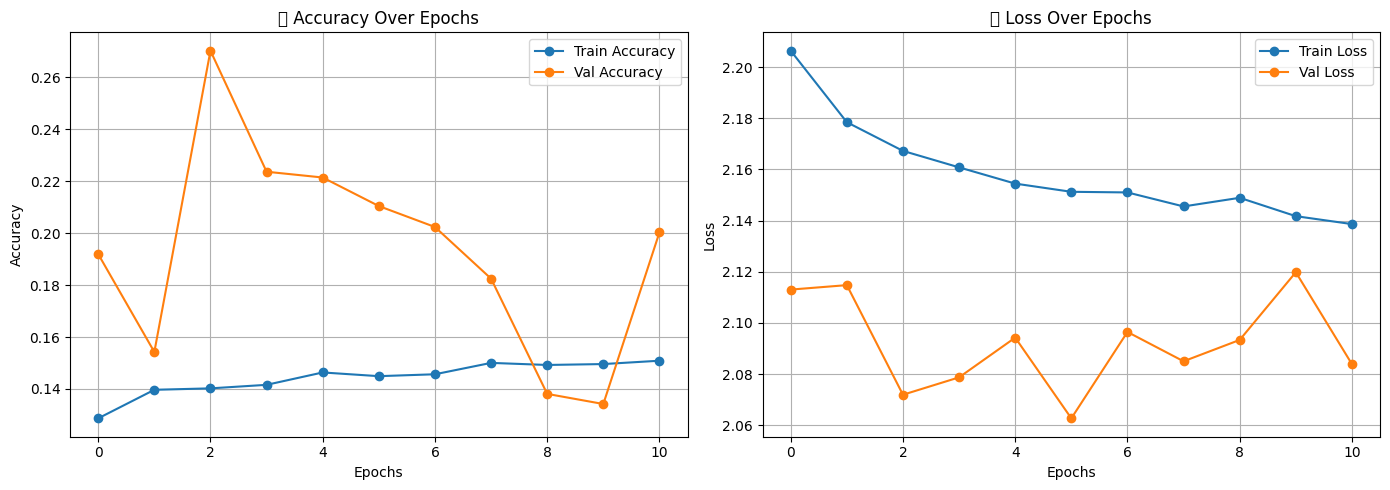


📊 Per-Class Accuracy:

Metals              : 96.36%
General Waste       : 96.62%
Organic Waste       : 99.50%
Glass               : 95.87%
Cardboard           : 93.81%
Paper               : 92.23%
Plastics            : 94.95%
Textiles            : 98.39%
Electronic Waste    : 97.35%


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Ground-truth labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model_efficientnet.predict(val_generator, verbose=1)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
report = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=3
)

print("🔍 Classification Report:\n")
print(report)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_effnet.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    total_per_class[label] += 1
    if label == pred:
        correct_per_class[label] += 1

print("\n📊 Per-Class Accuracy:\n")
for label_index, total in total_per_class.items():
    acc = correct_per_class[label_index] / total
    label_name = index_to_label[label_index]
    print(f"{label_name:20s}: {acc*100:.2f}%")


# **3.EfficientNetV2**

🧠 What Is EfficientNetV2 & Why Use It
EfficientNetV2 (2021) is the next-generation architecture from Google that improves on EfficientNet by optimizing training speed, parameter efficiency, and inference throughput using techniques like Fused-MBConv and progressive learning.

✅ Key Advantages for Your Garbage Classification Task:
Feature	Benefit
📏 Faster training	Trains significantly quicker than its predecessor, useful for iterating
⚖️ High parameter efficiency	Models deliver strong accuracy with fewer parameters (~10M)
🔁 Better on transfer learning	Learns effectively with fewer epochs, excellent on medium datasets
⚡ Well-suited for real-time	Combines speed & accuracy, ideal for deployment on stronger hardware



**3. 1. Define and Compile the Model**

this is B0 , we can swap to b1 b2 b3 with some code changes


In [ ]:
# from tensorflow.keras.applications import EfficientNetV2B0
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Load base model
# base_model = EfficientNetV2B0(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=Input(shape=(224, 224, 3))
# )
# base_model.trainable = False  # Freeze base layers

# # Add classification head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# model_efficientv2 = Model(inputs=base_model.input, outputs=outputs)

# # Compile the model
# model_efficientv2.compile(
#     optimizer=Adam(learning_rate=0.0003),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assume 'train_generator' has already been created, for example:
# train_generator = image_data_generator.flow_from_dataframe(...)

# Load base model
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)
base_model.trainable = False  # Freeze base layers

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
# Corrected line:
outputs = Dense(len(train_generator.class_indices), activation='softmax')(x)

model_efficientv2 = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model_efficientv2.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# You can now proceed to train your model
# model_efficientv2.fit(train_generator, ...)


**3.2. Set Up Callbacks for Training**

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy', verbose=1)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6, verbose=1)


**3.3. Train the Model**

In [ ]:
history_v2 = model_efficientv2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3130']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3130']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0978 - loss: 2.2465

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3130']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


899/899 ━━━━━━━━━━━━━━━━━━━━ 114s 95ms/step - accuracy: 0.0979 - loss: 2.2464 - val_accuracy: 0.0953 - val_loss: 2.1767 - learning_rate: 3.0000e-04
Epoch 2/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.1065 - loss: 2.2205 - val_accuracy: 0.1342 - val_loss: 2.1810 - learning_rate: 3.0000e-04
Epoch 3/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.1010 - loss: 2.2180 - val_accuracy: 0.1179 - val_loss: 2.2000 - learning_rate: 3.0000e-04
Epoch 4/20
898/899 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1133 - loss: 2.1800
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
899/899 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.1133 - loss: 2.1801 - val_accuracy: 0.1299 - val_loss: 2.2171 - learning_rate: 3.0000e-04
Epoch 5/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 86s 67ms/step - accuracy: 0.1045 - loss: 2.2062 - val_accuracy: 0.1872 - val_loss: 2.1482 - learning_rate: 1.5000e-04
Epoch 6/20
899/899 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.

**3.3 evaluation**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 1. Predict on validation set
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
y_pred_probs = model_efficientv2.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Accuracy/Loss Curves
hist = history_v2.history  # or history_v2_ft.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], marker='o', label='Train Acc')
plt.plot(hist['val_accuracy'], marker='o', label='Val Acc')
plt.title('📈 Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist['loss'], marker='o', label='Train Loss')
plt.plot(hist['val_loss'], marker='o', label='Val Loss')
plt.title('📉 Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# 5. Per-class accuracy
correct = defaultdict(int)
total = defaultdict(int)
for i in range(len(y_true)):
    total[y_true[i]] += 1
    if y_true[i] == y_pred[i]:
        correct[y_true[i]] += 1

print("\n📊 Per-Class Accuracy:")
for idx, cnt in total.items():
    acc = correct[idx] / cnt
    print(f"{index_to_label[idx]:20s}: {acc*100:.2f}%")


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 1. Predict on validation set
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
y_pred_probs = model_efficientv2.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Accuracy/Loss Curves
hist = history_v2.history  # or history_v2_ft.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], marker='o', label='Train Acc')
plt.plot(hist['val_accuracy'], marker='o', label='Val Acc')
plt.title('📈 Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist['loss'], marker='o', label='Train Loss')
plt.plot(hist['val_loss'], marker='o', label='Val Loss')
plt.title('📉 Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# 5. Per-class accuracy
correct = defaultdict(int)
total = defaultdict(int)
for i in range(len(y_true)):
    total[y_true[i]] += 1
    if y_true[i] == y_pred[i]:
        correct[y_true[i]] += 1

print("\n📊 Per-Class Accuracy:")
for idx, cnt in total.items():
    acc = correct[idx] / cnt
    print(f"{index_to_label[idx]:20s}: {acc*100:.2f}%")


# **3.2 fine-tune efficientNetv2**


In [ ]:
base_model.trainable = True

model_efficientv2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_v2_ft = model_efficientv2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 1. Predict on validation set
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
y_pred_probs = model_efficientv2.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Classification report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Accuracy/Loss Curves
hist = history_v2.history  # or history_v2_ft.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], marker='o', label='Train Acc')
plt.plot(hist['val_accuracy'], marker='o', label='Val Acc')
plt.title('📈 Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist['loss'], marker='o', label='Train Loss')
plt.plot(hist['val_loss'], marker='o', label='Val Loss')
plt.title('📉 Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# 5. Per-class accuracy
correct = defaultdict(int)
total = defaultdict(int)
for i in range(len(y_true)):
    total[y_true[i]] += 1
    if y_true[i] == y_pred[i]:
        correct[y_true[i]] += 1

print("\n📊 Per-Class Accuracy:")
for idx, cnt in total.items():
    acc = correct[idx] / cnt
    print(f"{index_to_label[idx]:20s}: {acc*100:.2f}%")


In [ ]:
# Save the ResNet50 model
model_resnet.save("resnet50_model.h5")

print("ResNet50 model saved as resnet50_model.h5")

In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("resnet50_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Quantization for speed (float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted to model.tflite")

In [ ]:
# Save the fine-tuned ResNet50 model
model_finetuned.save("fine_tuned_resnet50_model.h5")

print("Fine-tuned ResNet50 model saved as fine_tuned_resnet50_model.h5")

In [ ]:
import tensorflow as tf

# Load your trained model (the fine-tuned ResNet50)
model = tf.keras.models.load_model("fine_tuned_resnet50_model.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Quantization for speed (float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model
with open("fine_tuned_resnet50_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Fine-tuned ResNet50 model converted to fine_tuned_resnet50_model.tflite")

In [ ]:
import joblib

# Save the SVM model
joblib.dump(svm_classifier, "svm_classifier_model.joblib")

print("SVM classifier model saved as svm_classifier_model.joblib")